Aim: poisson decomposition of bulk data.


In [1]:
from util._io import read_config
from collections import namedtuple
from pathlib import Path
import pandas as pd
import numpy as np
import fastsca
import logging

In [2]:
experiment = '/projects/experiments/fastsca/'
server = Path.home().as_posix()
experiment_home = server+experiment
experiment_config = read_config(experiment_home+'config.yaml')
args = namedtuple('Struct',experiment_config.keys())(*experiment_config.values())

sca = fastsca.FASTSCA()
sca.config = args
sca.initdata()
sca.loaddata()
sca.data.mtx.shape

(155913, 20265)

In [3]:
fpath = sca.config.home + sca.config.experiment +sca.config.output + sca.config.sample_id+'/'+sca.config.sample_id
df = pd.read_csv(fpath+"_rp_bulk.csv.gz")
df.shape

(3257, 20265)

In [4]:
import _pmf
import importlib
importlib.reload(_pmf)

<module '_pmf' from '/home/BCCRC.CA/ssubedi/projects/experiments/fastsca/fastsca/_pmf.py'>

In [5]:
m = _pmf.PoissonMF(n_components=10)
m.fit(df.to_numpy())

/home/BCCRC.CA/ssubedi/projects/experiments/fastsca/fastsca/_pmf.py:127: RuntimeWarning: invalid value encountered in double_scalars
  improvement = (bound - old_bd) / abs(old_bd)


	After ITERATION: 0	Objective: 5095681100.47	Old objective: -inf	Improvement: nan
	After ITERATION: 1	Objective: 5096956637.44	Old objective: 5095681100.47	Improvement: 0.00025
	After ITERATION: 2	Objective: 5101019412.79	Old objective: 5096956637.44	Improvement: 0.00080
	After ITERATION: 3	Objective: 5110581428.53	Old objective: 5101019412.79	Improvement: 0.00187
	After ITERATION: 4	Objective: 5124926213.34	Old objective: 5110581428.53	Improvement: 0.00281
	After ITERATION: 5	Objective: 5139244829.73	Old objective: 5124926213.34	Improvement: 0.00279
	After ITERATION: 6	Objective: 5149904066.53	Old objective: 5139244829.73	Improvement: 0.00207
	After ITERATION: 7	Objective: 5158668631.25	Old objective: 5149904066.53	Improvement: 0.00170
	After ITERATION: 8	Objective: 5168522536.18	Old objective: 5158668631.25	Improvement: 0.00191
	After ITERATION: 9	Objective: 5181909545.14	Old objective: 5168522536.18	Improvement: 0.00259
	After ITERATION: 10	Objective: 5200351092.73	Old objective: 51

In [6]:
H = m.gamma_b
W = m.gamma_t

In [7]:
H.max(1)

array([ 6502448.09983273,  4219866.72908989,  2441769.90904154,
        1916742.38201514,  1159795.28892259,  8758106.12703174,
        1213081.09970317,  6053524.38707936, 16158707.36061627,
        4946175.12571346])

In [52]:
from sklearn.decomposition import NMF
model = NMF(n_components=10, init='random', random_state=0)
W = model.fit_transform(df.to_numpy())
H = model.components_


/home/BCCRC.CA/ssubedi/.conda/envs/ssubedi/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [ ]:
import _topics_util as tpu 

dfh = pd.DataFrame(H)

dfh.columns = sca.data.cols
df_top = tpu.get_topic_top_genes(dfh,10)

df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')

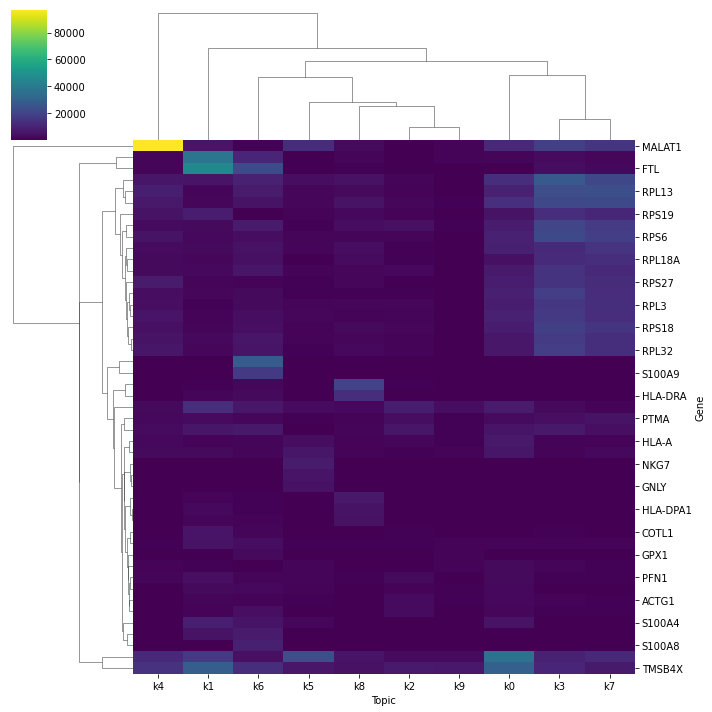

In [12]:
#pbmc
import matplotlib.pylab as plt
import seaborn as sns
sns.clustermap(df_top.T,cmap='viridis')

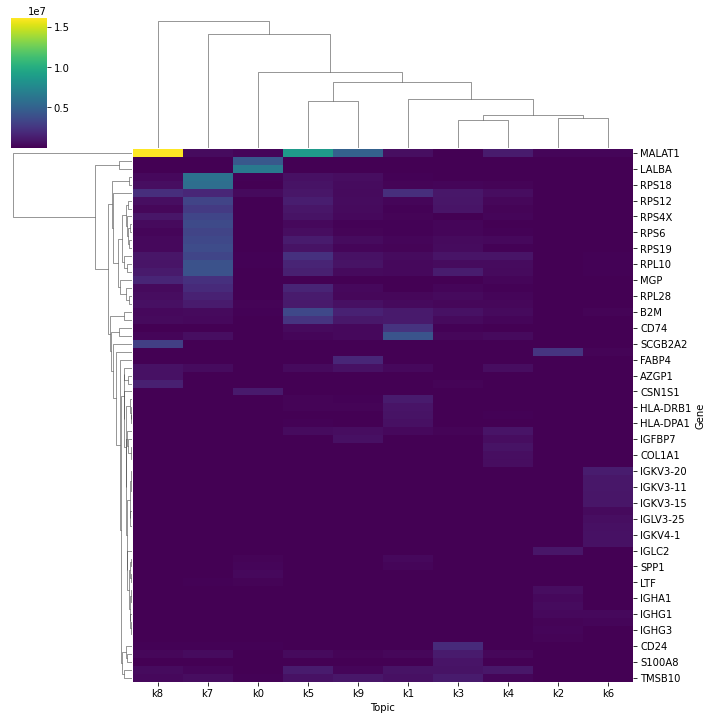

In [9]:
#tnbc 
import matplotlib.pylab as plt
import seaborn as sns
sns.clustermap(df_top.T,cmap='viridis')

In [10]:
df_theta = pd.DataFrame(W)
df_theta['celltopic'] = [x for x in df_theta.iloc[:,1:].idxmax(axis=1)]
df_theta = df_theta[['celltopic']]

In [11]:
fpath = sca.config.home + sca.config.experiment +sca.config.output + sca.config.sample_id+'/'+sca.config.sample_id
df_index = pd.read_csv(fpath+"_rp_bulk_index.csv.gz")


In [12]:
cell_topic_assignment = []
for indx,row in df_index.iterrows():
    for i in row[pd.Series(row).notna()].values:
        cell_topic_assignment.append([int(i),df_theta.loc[indx,'celltopic']])

In [13]:
df_pmf = pd.DataFrame(cell_topic_assignment,columns=['cell_index','topic'])
df_pmf = df_pmf.sort_values('cell_index')
df_pmf['index'] = sca.data.rows


In [14]:
df_pmf

,cell_index,topic,index
107280,0,9,CID3586_AAGACCTCAGCATGAG_GSE176078
107948,1,5,CID3586_AAGGTTCGTAGTACCT_GSE176078
16807,2,1,CID3586_ACCAGTAGTTGTGGCC_GSE176078
37156,3,8,CID3586_ACCCACTAGATGTCGG_GSE176078
63063,4,4,CID3586_ACTGATGGTCAACTGT_GSE176078
...,...,...,...
39087,155908,4,TTTGTTGCAGAGGAAA-1_GSM5022606_D11_GSE164898
39044,155909,4,TTTGTTGCATGCCATA-1_GSM5022606_D11_GSE164898
102388,155910,1,TTTGTTGCATTGCCTC-1_GSM5022606_D11_GSE164898
31111,155911,7,TTTGTTGGTTGCATCA-1_GSM5022606_D11_GSE164898


In [15]:
fpath = sca.config.home + sca.config.experiment +sca.config.output + sca.config.sample_id+'/'+sca.config.sample_id
df_pl = pd.read_csv(fpath+"_prior_label.csv.gz")
df_pl

,index,celltype
0,TGGGTTAAGTTACGTC-1_GSM5022606_D11_GSE164898,B
1,CATCCACGTGGCTTGC-1_GSM5022605_D6-D10_Pool_HN_G...,B
2,GTTGTCCCATCCTTCG-1_GSM5022605_D6-D10_Pool_HN_G...,B
3,AAGCGTTGTTCTAAGC-1_GSM5022604_D6-D10_Pool_CMG_...,B
4,GTTCTATTCATTGAGC-1_GSM5022604_D6-D10_Pool_CMG_...,B
...,...,...
155908,CID4513_TCGTACCGTCAGAGGT_GSE176078,T
155909,CID3963_GTTCATTGTAACGACG_GSE176078,T
155910,CID4398_GGCAATTAGGGTCGAT_GSE176078,T
155911,CID44041_GACCTGGGTCAAAGCG_GSE176078,T


topic,1,2,3,4,5,6,7,8,9
celltype,,,,,,,,,
B,0.000000,0.000000,0.000000,0.000000,0.157453,0.000000,0.104205,0.083820,0.088620
CAF,0.000000,0.000000,0.000000,0.360319,0.000000,0.000000,0.000000,0.000000,0.000000
Cancer,0.056204,0.148211,0.682235,0.086447,0.000000,0.126582,0.116586,0.538990,0.000000
Endothelial,0.060173,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.400610
Epithelial,0.068667,0.000000,0.000000,0.056515,0.000000,0.000000,0.441432,0.000000,0.103586
Myeloid,0.612844,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.065145
PVL,0.000000,0.000000,0.000000,0.197670,0.000000,0.000000,0.000000,0.000000,0.073596
Plasma,0.000000,0.544293,0.000000,0.092875,0.000000,0.585707,0.105057,0.122832,0.000000
T,0.095975,0.156729,0.096848,0.114303,0.652213,0.085707,0.090121,0.067234,0.127648


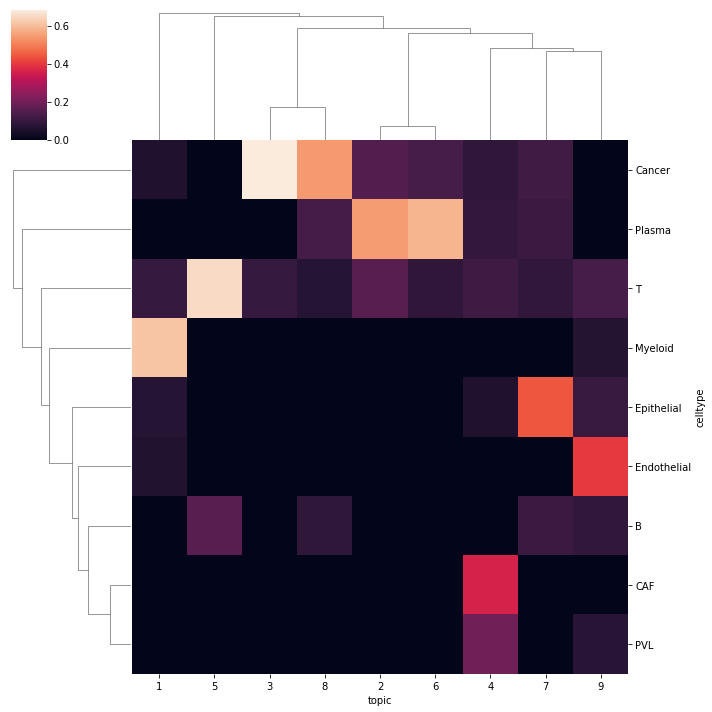

In [21]:
df_join = pd.merge(df_pl,df_pmf,on='index')
df_match = df_join.groupby(['celltype','topic']).count().reset_index()
df_match = df_match.pivot('celltype','topic','index')
df_match = df_match.fillna(0)
df_match = df_match/df_match.sum(0)

df_match[df_match<0.05]=0.0
import matplotlib.pylab as plt
import seaborn as sns
sns.clustermap(df_match)
df_match


In [18]:
df_join

,index,celltype,cell_index,topic
0,TGGGTTAAGTTACGTC-1_GSM5022606_D11_GSE164898,B,155157,5
1,CATCCACGTGGCTTGC-1_GSM5022605_D6-D10_Pool_HN_G...,B,140685,5
2,GTTGTCCCATCCTTCG-1_GSM5022605_D6-D10_Pool_HN_G...,B,144835,5
3,AAGCGTTGTTCTAAGC-1_GSM5022604_D6-D10_Pool_CMG_...,B,127340,9
4,GTTCTATTCATTGAGC-1_GSM5022604_D6-D10_Pool_CMG_...,B,134784,5
...,...,...,...,...
155908,CID4513_TCGTACCGTCAGAGGT_GSE176078,T,47264,5
155909,CID3963_GTTCATTGTAACGACG_GSE176078,T,61093,5
155910,CID4398_GGCAATTAGGGTCGAT_GSE176078,T,98956,5
155911,CID44041_GACCTGGGTCAAAGCG_GSE176078,T,21076,5


topic,1,2,3,4,5,6,7,8,9
leiden,,,,,,,,,
0,0.000000,0.0,0.505976,0.0,0.000000,0.000000,0.0,0.000,0.0
1,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000,0.0
2,0.000000,0.0,0.000000,0.0,0.000000,0.808864,0.0,0.000,0.0
3,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.525,0.0
4,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000,0.0
5,0.540625,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000,0.0
6,0.000000,0.0,0.000000,0.0,0.516949,0.000000,0.0,0.000,0.0
7,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000,0.0
8,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000,0.5


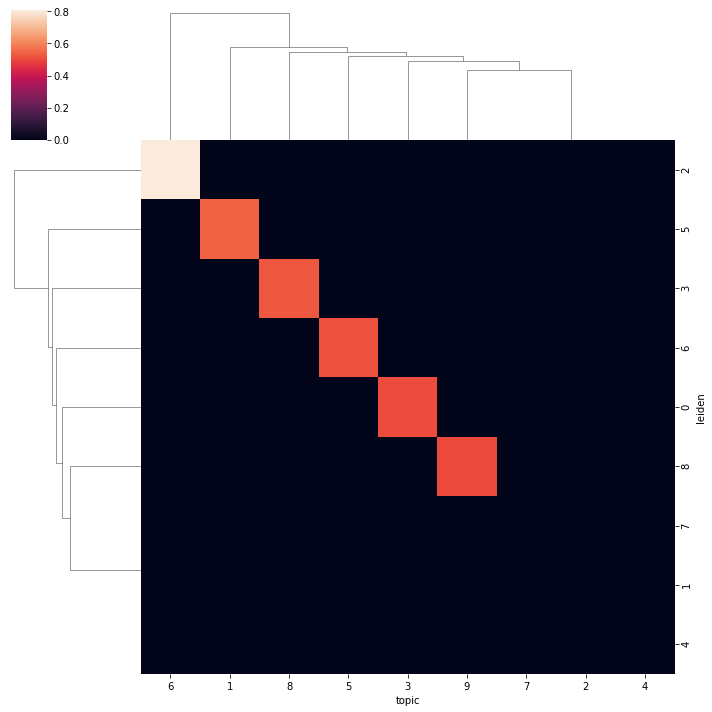

In [83]:

#pbmc 

df_join = pd.merge(df_pl,df_pmf,on='index')
df_match = df_join.groupby(['leiden','topic']).count().reset_index()
df_match = df_match.pivot('leiden','topic','index')
df_match = df_match.fillna(0)
df_match = df_match/df_match.sum(0)

df_match[df_match<0.5]=0.0
import matplotlib.pylab as plt
import seaborn as sns
sns.clustermap(df_match)
df_match


In [65]:
df_match.sum().sum()

2638.0

In [ ]:
### compare with etm

df_etm = pd.read_csv(fpath+'_rp_model_h.csv.gz')
df_etm['celltopic'] = [x.replace('h','') for x in df_etm.iloc[:,1:].idxmax(axis=1)]
df_etm = df_etm[['cell','celltopic']]

df_join = pd.merge(df_pl,df_etm,on='cell')
df_match = df_join.groupby(['celltype','celltopic']).count().reset_index()
df_match = df_match.pivot('celltype','celltopic','cell')
import matplotlib.pylab as plt
import seaborn as sns
sns.clustermap(df_match)